In [ ]:
# cost roughly $1 of gpt 5 to run this report, not perfect, since wilson uses IMAGES for some holdings data like wtf.
# TODO: add link next to each entry so can verify later.
API_KEY=

In [ ]:
# === CONFIGURATION ===
MODEL = "gpt-5"   # or "gpt-4o-mini" if you don’t have GPT-5 API access

from openai import OpenAI
import requests, pdfplumber, pandas as pd, re, json, math
from io import BytesIO
from calendar import month_name, month_abbr

client = OpenAI(api_key=API_KEY)

BASE = "https://wilsonassetmanagement.com.au/wp-content/uploads"
TICKERS = ["WAA","WAM","WAR","WAX","WGB","WLE","WMA","WMI","WMX"]
YEAR = 2025
HTTP_TIMEOUT = 45
MAX_CHARS_PER_CHUNK = 12000


In [7]:
# === URL + PDF UTILITIES ===

def prefix_for_report_month(m):  # July=1 ... June=12
    return ((m - 7) % 12) + 1

def dir_year_month(year, m):     # directory is one month ahead of report
    return (year + 1, 1) if m == 12 else (year, m + 1)

def month_variants(m):
    full, abbr = month_name[m], month_abbr[m]
    variants = {full}
    if abbr and abbr != full:
        variants.add(abbr)
    return sorted(variants)

def estimate_urls_for_year(year=YEAR):
    urls = []
    for report_month in range(1, 13):
        prefix = prefix_for_report_month(report_month)
        dir_y, dir_m = dir_year_month(year, report_month)
        for mv in month_variants(report_month):
            for t in TICKERS:
                fname = f"{prefix}.-{mv}-2025_{t}.pdf"
                url = f"{BASE}/{dir_y:04d}/{dir_m:02d}/{fname}"
                urls.append((f"{mv}-2025", t, url))
    return urls

def url_exists(url):
    try:
        r = requests.head(url, timeout=HTTP_TIMEOUT, allow_redirects=True)
        if r.status_code == 200:
            return True
        if r.status_code in (403, 405):
            r = requests.get(url, stream=True, timeout=HTTP_TIMEOUT)
            ok = r.status_code == 200
            r.close()
            return ok
    except requests.RequestException:
        pass
    return False

def fetch_pdf_text(url):
    r = requests.get(url, timeout=HTTP_TIMEOUT)
    r.raise_for_status()
    with pdfplumber.open(BytesIO(r.content)) as pdf:
        text = "\n".join(
            f"\n\n--- PAGE {i+1} ---\n" + (p.extract_text() or "")
            for i, p in enumerate(pdf.pages)
        )
    return text

def chunk_text(text, max_chars=MAX_CHARS_PER_CHUNK):
    for i in range(0, len(text), max_chars):
        yield text[i:i+max_chars]


In [8]:
SYSTEM_MSG = "You are a strict extraction engine. Output JSON only, no prose."

def prompt_for_codes(date_label, ticker, url, text_chunk):
    return f"""
Extract stock holding codes from this PDF text chunk for "Top 10 holdings" or "Top 20 holdings".
Return ONLY valid JSON with shape:
{{
  "list_type": "Top 10" | "Top 20" | "None",
  "codes": ["BHP","ANZ","..."]  // up to 20
}}
If nothing found, return:
{{"list_type":"None","codes":[]}}
Meta: date={date_label}, ticker={ticker}, url={url}
TEXT:
{text_chunk}
"""

def llm_extract_codes(date_label, ticker, url, text):
    all_codes, saw_top20 = set(), False
    for chunk in chunk_text(text):
        prompt = prompt_for_codes(date_label, ticker, url, chunk)
        kwargs = {
            "model": MODEL,
            "messages": [
                {"role": "system", "content": SYSTEM_MSG},
                {"role": "user", "content": prompt},
            ],
        }
        resp = client.chat.completions.create(**kwargs)
        raw = resp.choices[0].message.content.strip()
        if raw.startswith("```"):
            raw = re.sub(r"^```(json)?", "", raw, flags=re.I).rstrip("`").strip()
        try:
            obj = json.loads(raw)
        except json.JSONDecodeError:
            continue
        lt = obj.get("list_type", "None")
        codes = obj.get("codes", []) or []
        if lt.lower() == "top 20":
            saw_top20 = True
        for c in codes:
            c = c.strip().upper()
            if re.fullmatch(r"[A-Z0-9.\-]{1,10}", c):
                all_codes.add(c)
    limit = 20 if saw_top20 else 10
    return sorted(all_codes)[:limit]


In [9]:
def main():
    candidates = estimate_urls_for_year(YEAR)
    rows = []
    for date_label, ticker, url in candidates:
        if not url_exists(url):
            continue
        try:
            text = fetch_pdf_text(url)
        except Exception:
            continue
        codes = llm_extract_codes(date_label, ticker, url, text)
        for code in codes:
            rows.append({
                "date": date_label,
                "client": "Wilson Asset Management",
                "portfolio": ticker,
                "stock": code
            })

    df = pd.DataFrame(rows, columns=["date","client","portfolio","stock"])
    print(df)
    df.to_csv("wam_holdings_2025_llm.csv", index=False)
    print("\nSaved to wam_holdings_2025_llm.csv")

if __name__ == "__main__":
    main()


Cannot set gray non-stroke color because /'P0' is an invalid float value
Cannot set gray non-stroke color because /'P1' is an invalid float value
Cannot set gray non-stroke color because /'P0' is an invalid float value
Cannot set gray non-stroke color because /'P1' is an invalid float value
Cannot set gray non-stroke color because /'P0' is an invalid float value
Cannot set gray non-stroke color because /'P1' is an invalid float value
Cannot set gray non-stroke color because /'P0' is an invalid float value
Cannot set gray non-stroke color because /'P1' is an invalid float value
Cannot set gray non-stroke color because /'P0' is an invalid float value
Cannot set gray non-stroke color because /'P1' is an invalid float value
Cannot set gray non-stroke color because /'P0' is an invalid float value
Cannot set gray non-stroke color because /'P1' is an invalid float value
Cannot set gray non-stroke color because /'P3382' is an invalid float value
Cannot set gray non-stroke color because /'P3440

             date                   client portfolio stock
0    January-2025  Wilson Asset Management       WAA   360
1    January-2025  Wilson Asset Management       WAA   A2M
2    January-2025  Wilson Asset Management       WAA   ADH
3    January-2025  Wilson Asset Management       WAA   ALQ
4    January-2025  Wilson Asset Management       WAA   AMP
..            ...                      ...       ...   ...
917      Sep-2025  Wilson Asset Management       WMX   ORA
918      Sep-2025  Wilson Asset Management       WMX   RIO
919      Sep-2025  Wilson Asset Management       WMX   SGP
920      Sep-2025  Wilson Asset Management       WMX   WBC
921      Sep-2025  Wilson Asset Management       WMX   WTC

[922 rows x 4 columns]

Saved to wam_holdings_2025_llm.csv


In [2]:
import pandas as pd

# load your CSV (replace path with your actual file)
df = pd.read_csv("wam_holdings_2025_llm.csv")

# preview
print(df.head())


           date                   client portfolio stock
0  January-2025  Wilson Asset Management       WAA   360
1  January-2025  Wilson Asset Management       WAA   A2M
2  January-2025  Wilson Asset Management       WAA   ADH
3  January-2025  Wilson Asset Management       WAA   ALQ
4  January-2025  Wilson Asset Management       WAA   AMP


In [22]:
grouped = (
    df.groupby(["portfolio", "date"])
      .size()
      .reset_index(name="count")
      .sort_values(["portfolio", "date"])
)
grouped

,portfolio,date,count
0,WAA,April-2025,20
1,WAA,Aug-2025,20
2,WAA,February-2025,20
3,WAA,January-2025,20
4,WAA,July-2025,19
5,WAA,March-2025,19
6,WAA,May-2025,20
7,WAA,Sep-2025,20
8,WAM,April-2025,20
9,WAM,Aug-2025,20


In [3]:
war = df[df["portfolio"] == "WAR"]
print(war)

             date                   client portfolio stock
40   January-2025  Wilson Asset Management       WAR   AOF
41   January-2025  Wilson Asset Management       WAR   CD2
42   January-2025  Wilson Asset Management       WAR   CD3
43   January-2025  Wilson Asset Management       WAR   CIN
44   January-2025  Wilson Asset Management       WAR   CIW
..            ...                      ...       ...   ...
847      Sep-2025  Wilson Asset Management       WAR   SOL
848      Sep-2025  Wilson Asset Management       WAR   TEK
849      Sep-2025  Wilson Asset Management       WAR   VG1
850      Sep-2025  Wilson Asset Management       WAR   WGB
851      Sep-2025  Wilson Asset Management       WAR   WQG

[139 rows x 4 columns]


In [28]:
months = sorted(war["date"].unique(), key=lambda x: pd.to_datetime(x, errors="coerce"))
for i in range(1, len(months)):
    prev, curr = months[i-1], months[i]
    prev_set = set(war.loc[war["date"]==prev, "stock"])
    curr_set = set(war.loc[war["date"]==curr, "stock"])
    added = curr_set - prev_set
    removed = prev_set - curr_set
    print(f"\n{prev} ➜ {curr}")
    print("Added:", added)
    print("Removed:", removed)



January-2025 ➜ February-2025
Added: set()
Removed: set()

February-2025 ➜ April-2025
Added: {'LSF'}
Removed: {'DSK'}

April-2025 ➜ May-2025
Added: {'LRT'}
Removed: {'TEK'}

May-2025 ➜ July-2025
Added: {'TEK', 'OPH'}
Removed: {'GDC', 'CIW'}

July-2025 ➜ Aug-2025
Added: set()
Removed: {'PAI'}

Aug-2025 ➜ Sep-2025
Added: {'GDC', 'SOL', 'CIW'}
Removed: {'PMC', 'CD2'}


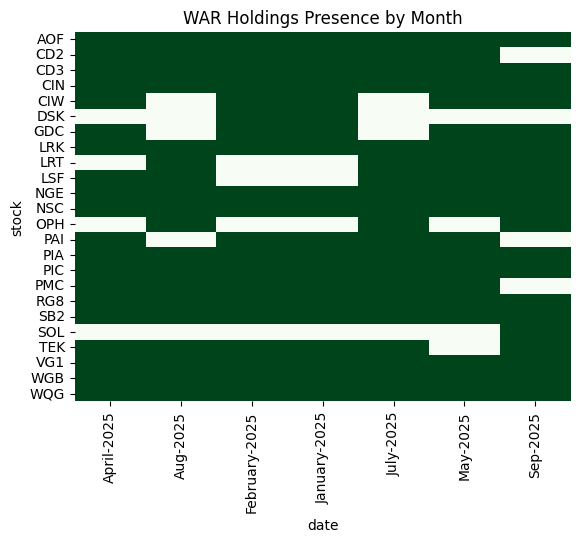

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

mat = pd.crosstab(war["stock"], war["date"]).astype(int)
mat = mat.loc[mat.sum(axis=1) > 0]  # remove stocks never used
sns.heatmap(mat, cmap="Greens", cbar=False)
plt.title("WAR Holdings Presence by Month")
plt.show()


In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os

# optional: where to store all images
os.makedirs("portfolio_heatmaps", exist_ok=True)

def parse_month(s):
    dt = pd.to_datetime(s, format="%B-%Y", errors="coerce")
    if pd.isna(dt):
        dt = pd.to_datetime(s, format="%b-%Y", errors="coerce")
    return dt

for portfolio, sub in df.groupby("portfolio"):
    if sub.empty:
        continue
    
    mat = pd.crosstab(sub["stock"], sub["date"]).astype(int)
    mat = mat.loc[mat.sum(axis=1) > 0]
    mat = mat.reindex(sorted(mat.columns, key=parse_month), axis=1)

    if mat.shape[0] < 2 or mat.shape[1] < 2:
        continue

    plt.figure(figsize=(10, max(6, len(mat)//2)))
    sns.heatmap(mat, cmap="Greens", cbar=False)
    plt.title(f"{portfolio} Holdings Presence by Month")
    plt.xlabel("Month")
    plt.ylabel("Stock")
    plt.tight_layout()

    # build filename
    fname = f"portfolio_heatmaps/{portfolio}_holdings_heatmap.png"
    plt.savefig(fname, dpi=300, bbox_inches="tight")
    plt.close()  # close the figure to free memory

    print(f"Saved: {fname}")


Saved: portfolio_heatmaps/WAA_holdings_heatmap.png
Saved: portfolio_heatmaps/WAM_holdings_heatmap.png
Saved: portfolio_heatmaps/WAR_holdings_heatmap.png
Saved: portfolio_heatmaps/WAX_holdings_heatmap.png
Saved: portfolio_heatmaps/WGB_holdings_heatmap.png
Saved: portfolio_heatmaps/WLE_holdings_heatmap.png
Saved: portfolio_heatmaps/WMI_holdings_heatmap.png
Saved: portfolio_heatmaps/WMX_holdings_heatmap.png
